In [1]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from aeon.io.reader import Reader, Csv
from dotmap import DotMap
import aeon.io.api as api
import os

root_folder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024_12_12-16_48_52/B6J2723-2024-12-12T15-44-01'
root_folder_photometry = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024_12_12-16_48_52/'

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
photometry_reader = utils.PhotometryReader("Fluorescence")
video_reader = utils.Video("VideoData1")
onix_digital_reader = utils.TimestampedCsvReader("OnixDigital", columns=["Clock", "HubClock", 
                                                                         "DigitalInputs0",
                                                                         "DigitalInputs1",
                                                                         "DigitalInputs2",
                                                                         "DigitalInputs3",
                                                                         "DigitalInputs4",
                                                                         "DigitalInputs5"
                                                                         "DigitalInputs6",
                                                                         "DigitalInputs7",
                                                                         "DigitalInputs8",
                                                                         "Buttons"])
onix_harp_reader = utils.TimestampedCsvReader("OnixHarp", columns=["Clock", "HubClock", "HarpTime"])

h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024_12_12-16_48_52/B6J2723-2024-12-12T15-44-01/HarpDataH1/'
h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024_12_12-16_48_52/B6J2723-2024-12-12T15-44-01/HarpDataH2/'

In [2]:
# read experiment metadata
session_settings = utils.load(session_data_reader, root_folder)

print(session_settings.iloc[0]['metadata'].blocks[1].haltProtocol)

DotMap(randomDelay=0.0, minumumDelay=0.0, haltGain=1.0, haltMotorGain=1.0, haltTime=2.0)


In [3]:
# read harp streams, experiment events, video
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
camera_triggers = utils.load_harp(h1_reader.Cam0Event, h1_datafolder)
experiment_events = utils.load(experiment_events_reader, root_folder)
video_data = utils.load(video_reader, root_folder)

                                                Event      Seconds
Time                                                              
1904-01-01 01:09:41.930240        Sync signal started  4181.930240
1904-01-01 01:09:50.999680     DrumBase block started  4190.999680
1904-01-01 01:09:51.120256            Homing platform  4191.120256
1904-01-01 01:09:51.680256  Wait for run threshold...  4191.680256
1904-01-01 01:11:51.120256        Block timer elapsed  4311.120256
...                                               ...          ...
1904-01-01 01:33:51.380256        Block timer elapsed  5631.380256
1904-01-01 01:33:51.380256     DrumBase block started  5631.380256
1904-01-01 01:33:51.390240            Homing platform  5631.390240
1904-01-01 01:33:51.890240  Wait for run threshold...  5631.890240
1904-01-01 01:35:51.400256        Block timer elapsed  5751.400256

[141 rows x 2 columns]


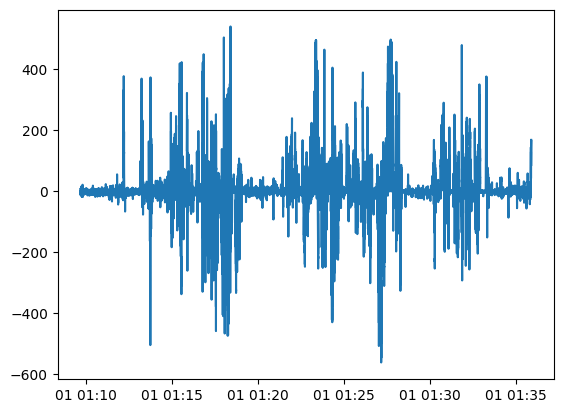

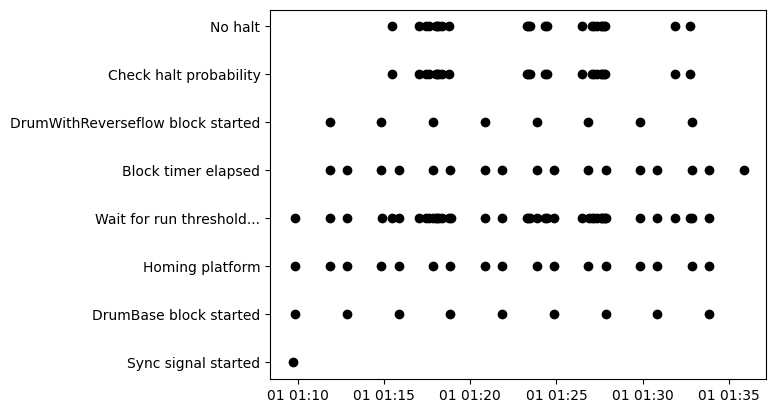

In [4]:
print(experiment_events)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0Y'])

plt.figure()
plt.scatter(experiment_events.index, experiment_events["Event"], c='k')

In [5]:
# read onix streams
# stream assigns a harp timestamp to each analog block
analog_frame_count = utils.load(framecount_reader, root_folder)

# load onix digital data
digital_data = utils.load(onix_digital_reader, root_folder)

# load harp timestamps
onix_harp = utils.load(onix_harp_reader, root_folder)
onix_harp["HarpTime"] = onix_harp["HarpTime"] + 1 # known issue with current version of ONIX, harp timestamps lag 1 second

# directly read an onix analog data / clock bin file
analog_data = utils.read_onix_analog_data(root_folder, "OnixAnalogData", np.int16)
analog_clock = utils.read_onix_analog_clock(root_folder, "OnixAnalogClock", np.uint64)

# confirm relationship between data, clock and frame count
print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])

36000000 157261100 1572611


C:\Users\neurogears\AppData\Local\Temp\ipykernel_27740\1770119561.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])


C:\Users\neurogears\AppData\Local\Temp\ipykernel_27740\1185024627.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(clock[window], harp[window], c='k', s=2)
C:\Users\neurogears\AppData\Local\Temp\ipykernel_27740\1185024627.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(clock[window], onix_to_harp_seconds(clock[window]), c='r')


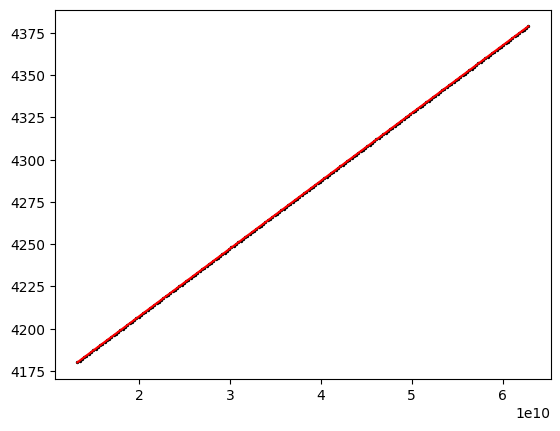

In [6]:
# define conversion functions between timestamps (onix to harp)
clock = onix_harp["Clock"] # ONIX hardware clock
harp = onix_harp["HarpTime"] # corresponding harp time

o_m, o_b = np.polyfit(clock, harp, 1)
onix_to_harp_seconds = lambda x: x*o_m + o_b
onix_to_harp_timestamp = lambda x: api.aeon(onix_to_harp_seconds(x))
harp_to_onix_clock = lambda x: (x - o_b) / o_m

window = range(0, 200)
plt.figure()
plt.scatter(clock[window], harp[window], c='k', s=2)
plt.plot(clock[window], onix_to_harp_seconds(clock[window]), c='r')

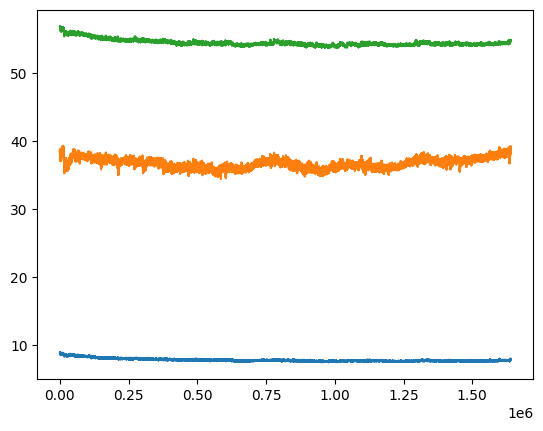

In [7]:
# read photometry stream
photometry = utils.load_photometry(photometry_reader, root_folder_photometry)

plt.figure()
plt.plot(photometry[0]["CH1-410"])
plt.plot(photometry[0]["CH1-470"])
plt.plot(photometry[0]["CH1-560"])

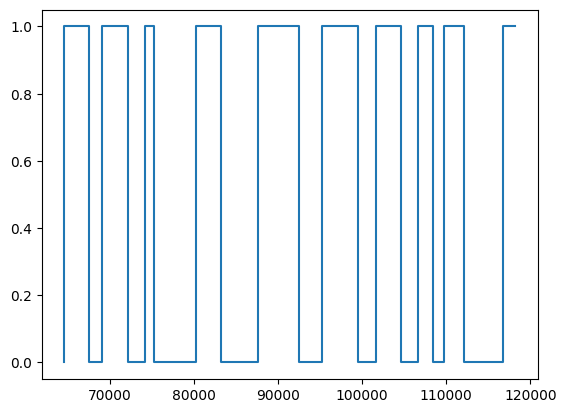

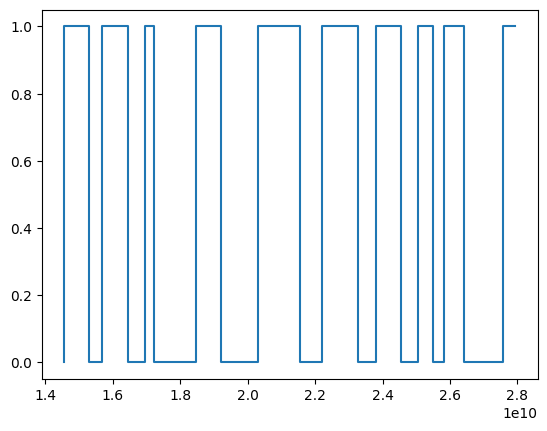

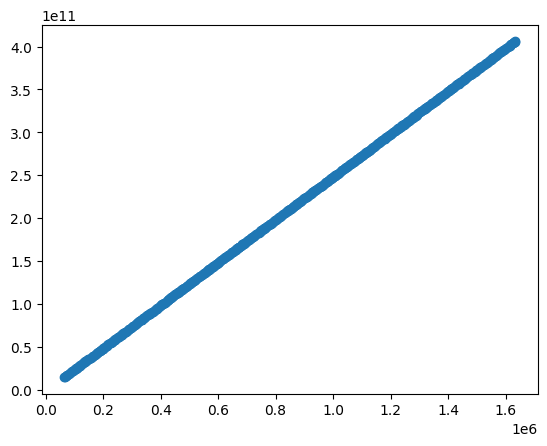

In [19]:
# photometry sync example
# binarise photometry input events
photometry_sync_events = photometry[0]["Events"]
photometry_sync_events = photometry_sync_events[~photometry_sync_events.isna()] # Restrict to events
photometry_sync_events = photometry_sync_events.transform(lambda x: int(x.split('*')[2])) # Extract channel value

# extract corresponding events in onix
digital_data["_sync_line"] = digital_data["DigitalInputs0"] == 'Pin1'

window = range(0, 20)
plt.figure()
plt.step(photometry_sync_events.index[window], photometry_sync_events.values[window])

plt.figure()
plt.step(digital_data.iloc[window]["Clock"], digital_data.iloc[window]["_sync_line"])

plt.figure()
plt.scatter(photometry_sync_events.index, digital_data["Clock"])

# define conversion functions between timestamps (onix to harp)
m, b = np.polyfit(photometry_sync_events.index, digital_data["Clock"], 1)
photometry_to_onix_time = lambda x: x*m + b
photometry_to_harp_time = lambda x: onix_to_harp_timestamp(photometry_to_onix_time(x))
onix_time_to_photometry = lambda x: (x - b) / m

In [20]:
# example, see harp data, experiment events, onix data for a given window, synchronised.
# where did the LinearRegularMismatch block start (approximately)?
block_start = experiment_events[experiment_events["Event"].eq("LinearRegularMismatch block started")]
print(block_start)

# Get the first 20 halt times after this block started
block_halts = experiment_events[(experiment_events["Event"].eq("Apply halt: 1s")) & (experiment_events.index > block_start.index[0])].iloc[0:20]

# Plot flow sensor and camera triggers during given halt period
idx = 0
sec_start = block_halts.index[idx]
sec_stop = block_halts.index[idx+1]
min_time = sec_start - pd.DateOffset(seconds=1)
max_time = sec_stop + pd.DateOffset(seconds=0.5)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0X'][min_time:max_time], label='Flow X')
plt.plot(flow_sensor['OpticalTrackingRead0Y'][min_time:max_time], label='Flow Y')
plt.scatter(camera_triggers[min_time:max_time].index, np.ones((1, len(camera_triggers[min_time:max_time]))) * -10, s=1, c='k', label='Camera Trigger')
plt.axvspan(sec_start, sec_start + pd.DateOffset(seconds=0.1), color='black', alpha=0.2, label='Halt Command')

# overlay the onix photodiode signal in converted time
onix_sec_start_time = harp_to_onix_clock(block_halts.iloc[idx]["Seconds"] - 1)
onix_sec_start_index = np.where(analog_clock >= onix_sec_start_time)[0][0]

onix_sec_stop_time = harp_to_onix_clock(block_halts.iloc[idx+1]["Seconds"])
onix_sec_stop_index = np.where(analog_clock >= onix_sec_stop_time)[0][0]
plt.plot(onix_to_harp_timestamp(analog_clock[onix_sec_start_index:onix_sec_stop_index]), analog_data[onix_sec_start_index:onix_sec_stop_index, 0], label='Photodiode')

# overlay photometry
photometry_sec_start_time = onix_time_to_photometry(onix_sec_start_time)
photometry_sec_stop_time = onix_time_to_photometry(onix_sec_stop_time)
photometry_sec = photometry[0].loc[(photometry[0].index >= photometry_sec_start_time) & (photometry[0].index <= photometry_sec_stop_time)]

plt.plot(photometry_to_harp_time(photometry_sec.index), photometry_sec['CH1-410'], label='CH1-410')

plt.legend()

Empty DataFrame
Columns: [Event, Seconds]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0